<a href="https://colab.research.google.com/github/devpriyagoel/Speech-Emotion-Recognition/blob/master/acrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Input, layers, Model, utils, initializers, losses, optimizers, Sequential, callbacks
import pickle

In [ ]:
input_shape = (300, 40, 3)
model_input = Input(shape=input_shape, name='log_mel_data')

Convolution Layer

In [ ]:
no_of_conv_layers = 6

x = layers.Conv2D(filters=128, kernel_size=(5, 3), strides=(1, 1),
                  padding='valid', bias_initializer=tf.constant_initializer(0.1),
                  kernel_initializer='glorot_uniform')(model_input)
x = layers.LeakyReLU(alpha=0.01)(x)
x = layers.MaxPooling2D((2, 2), strides=(1, 1))(x)

for _ in range(no_of_conv_layers - 1):
    x = layers.Conv2D(filters=256, kernel_size=(5, 3), strides=(1, 1),
                      padding='valid', bias_initializer=tf.constant_initializer(0.1),
                      kernel_initializer='glorot_uniform')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)

# Dropout layer only applies when training is set to True
# such that no values are dropped during inference.
# When using model.fit, training will be appropriately set to True automatically
x = layers.Dropout(rate=0)(x)

Linear Layer

In [ ]:
output_linear_units = 1000
time_step = x.shape[1]
linear_units = x.shape[2]*x.shape[3]
x = tf.reshape(x,[-1,time_step,linear_units])
x = tf.reshape(x, [-1, linear_units])

In [ ]:
linear1_weight = tf.Variable(initializers.TruncatedNormal(stddev=0.1)(shape=[linear_units, output_linear_units], dtype=tf.float32))
linear1_bias = tf.Variable(tf.constant_initializer(0.1)(shape=[output_linear_units], dtype=tf.float32))
x = tf.matmul(x, linear1_weight) + linear1_bias

In [ ]:
x = layers.BatchNormalization(momentum=0.999, epsilon=0.001)(x)
x = layers.LeakyReLU(alpha=0.01)(x)
x = tf.reshape(x, [-1, time_step, output_linear_units])

BiLSTM Layer

In [ ]:
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

Attention Layer

In [ ]:
W_omega = tf.Variable(initializers.RandomNormal(stddev=0.1)(shape=[x.shape[2], 1], dtype=tf.float32))
b_omega = tf.Variable(initializers.RandomNormal(stddev=0.1)(shape=[1], dtype=tf.float32))
u_omega = tf.Variable(initializers.RandomNormal(stddev=0.1)(shape=[1], dtype=tf.float32))
v = tf.sigmoid(tf.tensordot(x, W_omega, axes=1) + b_omega)
vu = tf.tensordot(v, u_omega, axes=1)
alphas = layers.Softmax()(vu)
x = tf.reduce_sum(x * tf.expand_dims(alphas, -1), 1)

Fully Connected Layer and Softmax

In [ ]:
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(4, activation="softmax")(x)

Compile Model

In [ ]:
model = Model(inputs=model_input, outputs=x, name="acrnn_model") 
model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Nadam(
        learning_rate=0.00001, beta_1=0.9),
    metrics=['categorical_accuracy'],
)

Display Model's Functional Graph

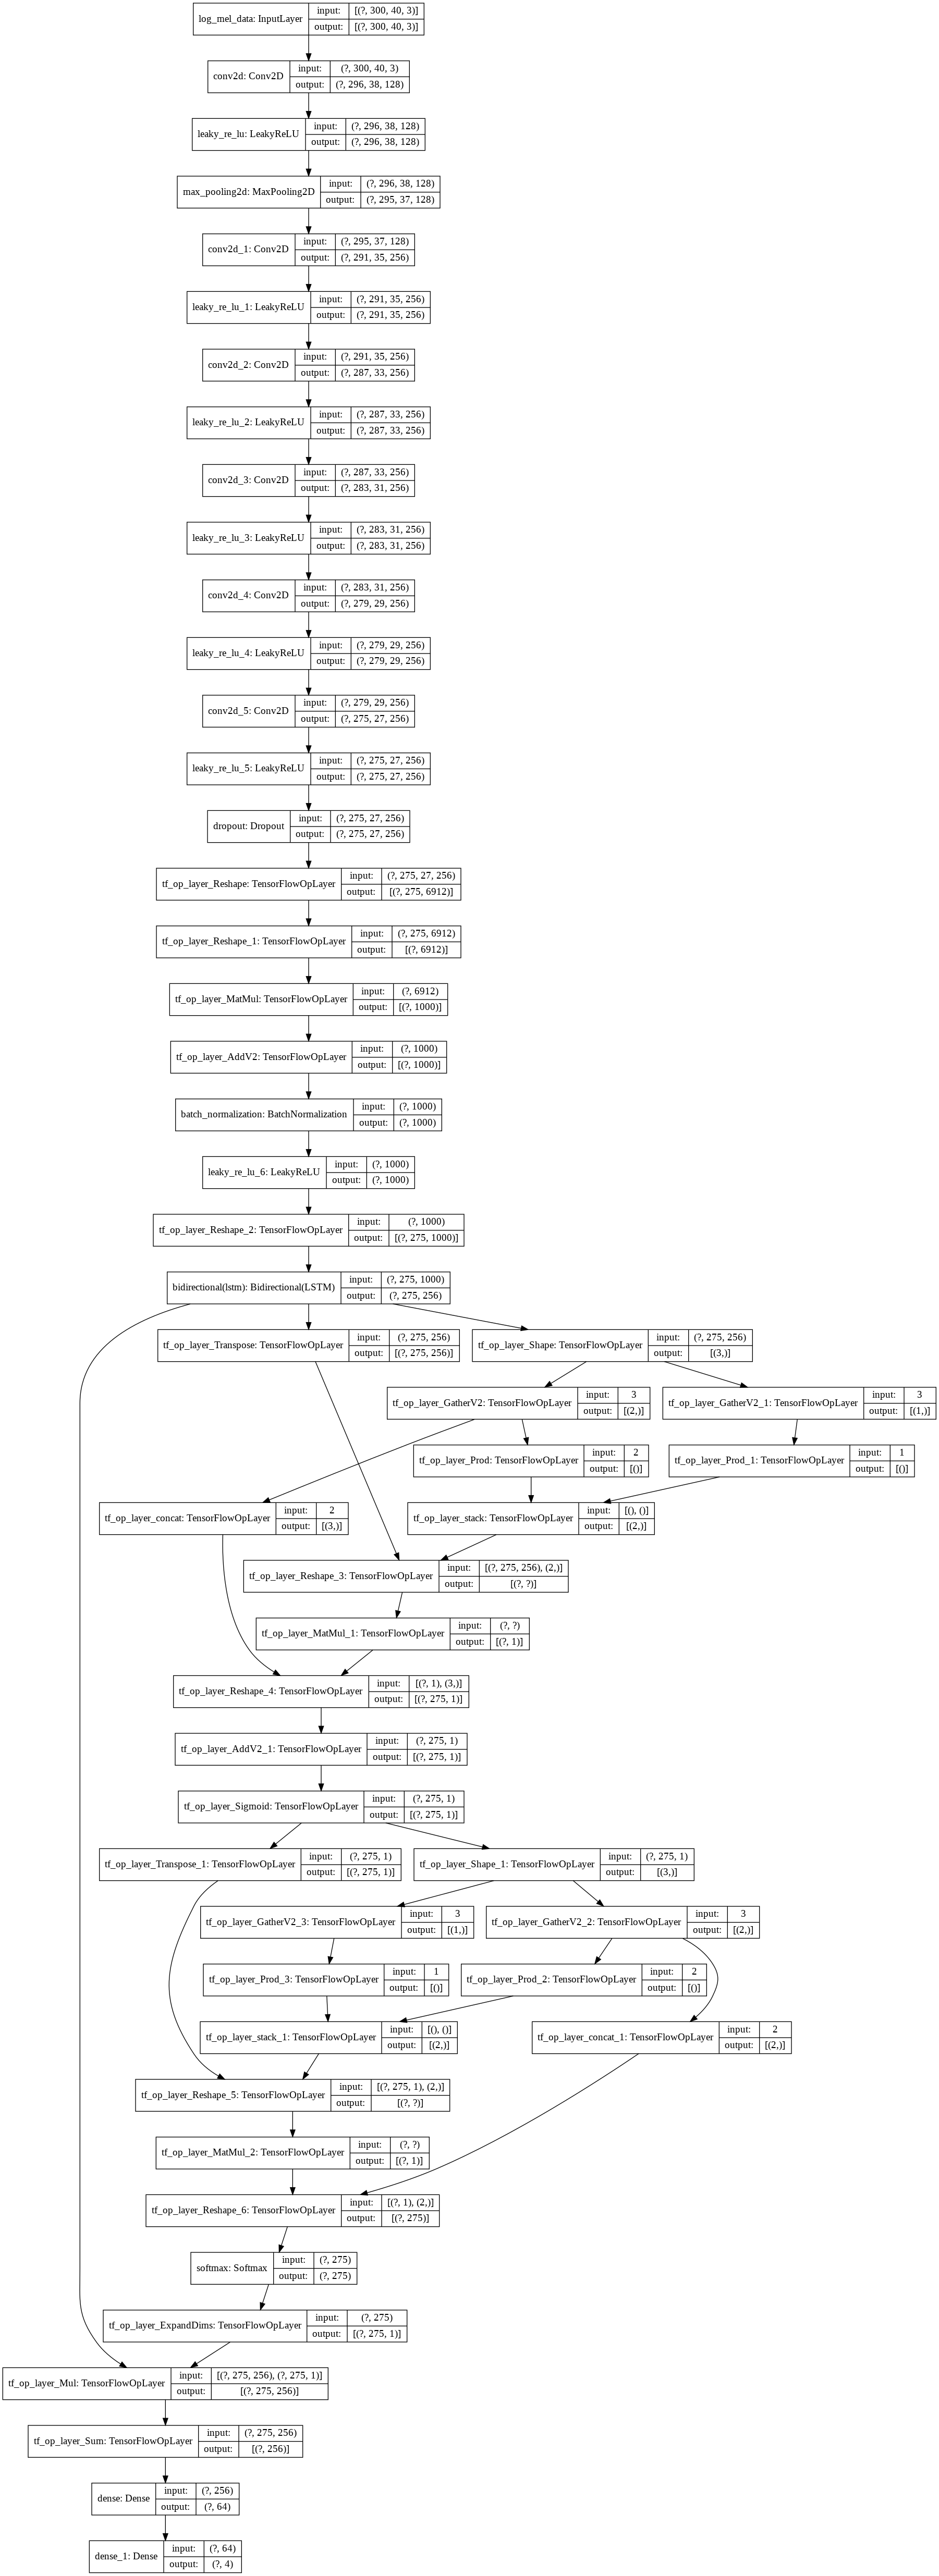

In [ ]:
utils.plot_model(model, show_shapes=True)

Retrieve Pre Processed Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/BTP - Dev Priya and Kushagra/Speech Emotion Recognition/Code"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/BTP - Dev Priya and Kushagra/Speech Emotion Recognition/Code


In [ ]:
f = open('./IEMOCAP_org.pkl','rb')
output = pickle.load(f)

In [ ]:
train_features, train_labels = output[:2]
test_features, test_labels = output[3], output[5]
valid_features, valid_labels = output[7], output[9]

In [ ]:
train_features = tf.convert_to_tensor(train_features, dtype=tf.float32)
valid_features = tf.convert_to_tensor(valid_features, dtype=tf.float32)
test_features = tf.convert_to_tensor(test_features, dtype=tf.float32)
train_labels = tf.one_hot(train_labels, 4, dtype=tf.float32)
valid_labels = tf.one_hot(valid_labels, 4, dtype=tf.float32)
test_labels = tf.one_hot(test_labels, 4, dtype=tf.float32)

In [ ]:
train_labels = tf.reshape(train_labels, [train_labels.shape[0], 4])
valid_labels = tf.reshape(valid_labels, [valid_labels.shape[0], 4])
test_labels = tf.reshape(test_labels, [test_labels.shape[0], 4])

In [ ]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)
print(valid_features.shape)
print(valid_labels.shape)

(1200, 300, 40, 3)
(1200, 4)
(420, 300, 40, 3)
(420, 4)
(436, 300, 40, 3)
(436, 4)


Training

In [ ]:
filepath="/content/acrnn_model.hdf5"
checkpointer = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(train_features, train_labels, batch_size=80, epochs=8, validation_split=0.20, callbacks=[checkpointer], shuffle=True)